In [1]:
from zipfile import ZipFile
from IPython.display import FileLink, FileLinks
import os
from pprint import pprint

import pickle

import time
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import statistics as stats
import numpy as np
from scipy.stats import mstats
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.stattools import jarque_bera

from statsmodels.api import OLS

import dash
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading CSVs into Pandas dataframes
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/grades_final.csv'
grades = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/pre_survey_final.csv'
pre_survey = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/post_survey_final.csv'
post_survey = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/delta_survey_final.csv'
delta_survey = pd.read_csv(path)

path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/dataset/my_dfs/sensing_final.csv'
sensing = pd.read_csv(path)

In [4]:
grades = grades.merge(sensing, on='uid', how='left')
grades.columns

Index(['uid', 'gpa_all', 'gpa_13s', 'academic', 'off_campus', 'cs_dept',
       'apartments', 'commons', 'living_learning', 'house', 'greek', 'library',
       'firstyear', 'primary', 'convo_num', 'convo_duration', 'duration_slope',
       'num_slope', 'dark', 'total_locked', 'avg_locked'],
      dtype='object')

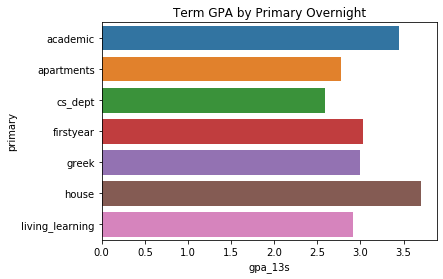

In [5]:
primary_gb = grades.groupby('primary').mean()
primary_gb = primary_gb[['convo_num',  'convo_duration', 'dark',
                         'duration_slope', 'num_slope',
                          'total_locked', 'avg_locked', 'gpa_13s']]

sns.barplot(
    y=primary_gb.index,
    x=primary_gb.gpa_13s
)
plt.title('Term GPA by Primary Overnight')
plt.show()

# 1. Predicting GPA with Sensing Data

# 1.1 Testing Assumptions for OLS

Ideally, I would love to be able to use OLS to build a model in order to get really specific interpretability for the effect of each variable on the model. However, I'm skeptical that OLS will be a powerful tool due to the very small size of the dataset. Nevertheless, before moving on to other algorithms I'm going to take a moment to test the assumptions of OLS on our data.

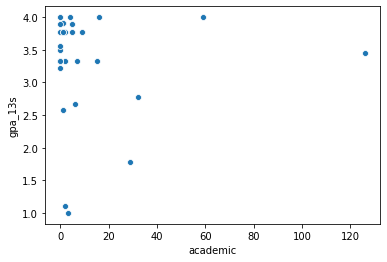

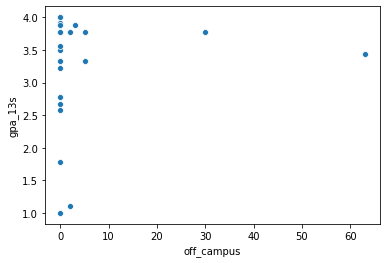

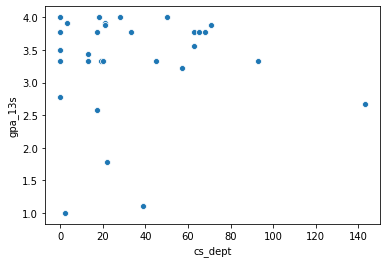

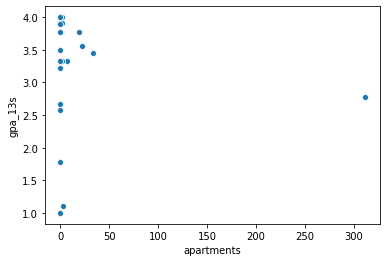

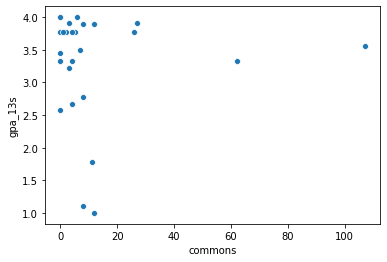

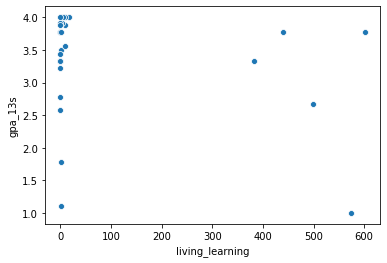

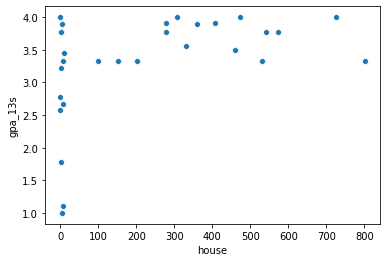

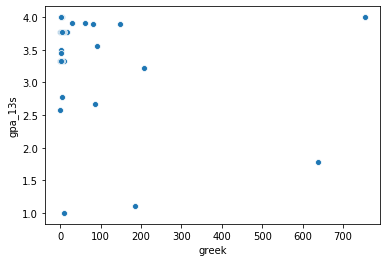

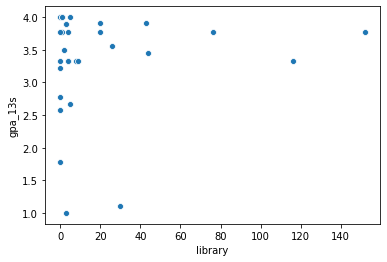

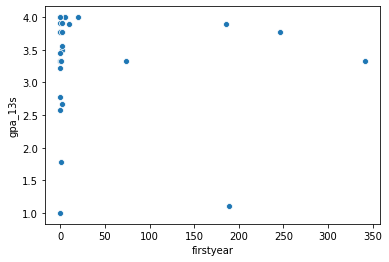

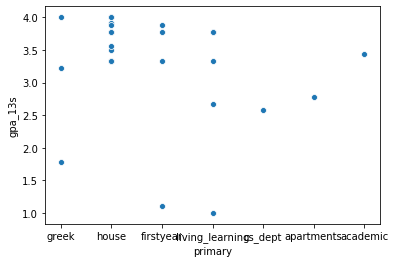

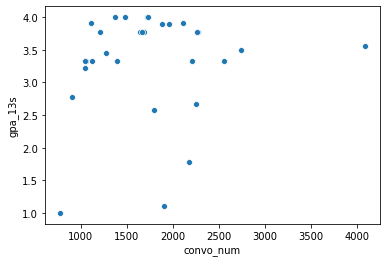

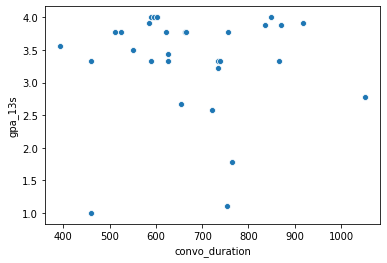

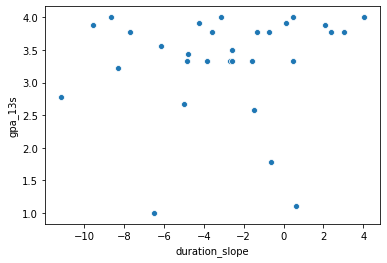

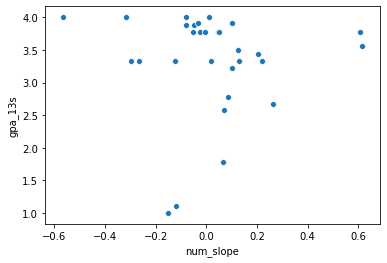

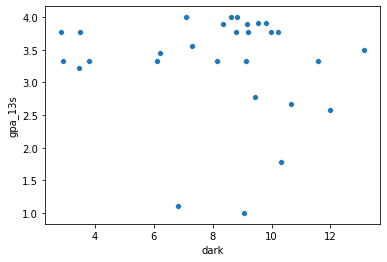

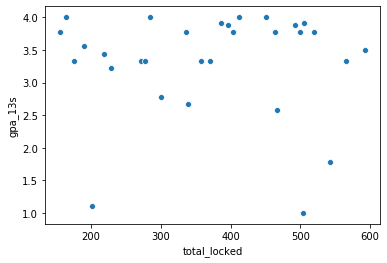

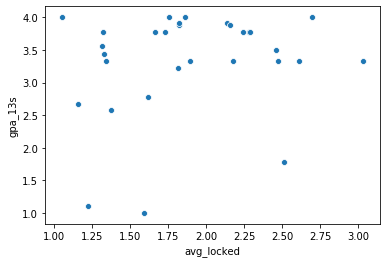

In [5]:
sensing_vars = ['academic', 'off_campus', 'cs_dept',
       'apartments', 'commons', 'living_learning', 'house', 'greek', 'library',
       'firstyear', 'primary', 'convo_num', 'convo_duration', 'duration_slope',
       'num_slope', 'dark', 'total_locked', 'avg_locked']

# Checking feature linearity
for var in sensing_vars:
    sns.scatterplot(
        x=grades[var],
        y=grades.gpa_13s
    )
    plt.show()

Of these, only `total_locked`, `house`, and `dark` seem to have much of a posibility of having a linear relationship with `gpa_13s`.

In [61]:
grades.columns

Index(['uid', 'gpa_all', 'gpa_13s', 'academic', 'off_campus', 'cs_dept',
       'apartments', 'commons', 'living_learning', 'house', 'greek', 'library',
       'firstyear', 'primary', 'convo_num', 'convo_duration', 'duration_slope',
       'num_slope', 'dark', 'total_locked', 'avg_locked'],
      dtype='object')

In [6]:
# Making sure mean of errors is close to zero
X = grades[['total_locked', 'house', 'dark']]
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = grades.gpa_13s

lr = LinearRegression()
lr.fit(X, y)
preds = lr.predict(X)
residuals = y - preds
np.mean(residuals)

-1.6283271027835628e-16

Mean of errors is close to zero.

In [7]:
# Testing for heteroscedasticity
_, pval, _, _ = het_breuschpagan(residuals, X)
pval

0.22886167899174795

The p-value is not beneath my alpha of 0.05, so I can assume homoscedasticity.

In [8]:
# Ensuring low multicolinearity
grades[['total_locked', 'house', 'dark']].corr()

,total_locked,house,dark
total_locked,1.000000,0.282515,0.620171
house,0.282515,1.000000,0.220573
dark,0.620171,0.220573,1.000000


Because there's some degree of colinearity between `total_locked` and `dark`, I should stay aware when I am interpreting coefficients that there may be some blending between these two variables. However, the correlation is low enough that I think the information from the coefficients would still be useful.

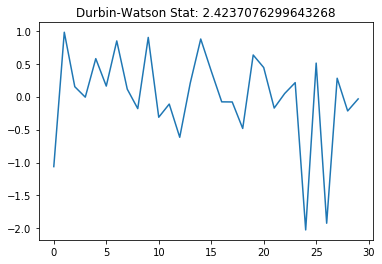

In [9]:
# Making sure residuals aren't autocorrelated
plt.plot(residuals)
plt.title('Durbin-Watson Stat: {}'.format(durbin_watson(residuals)))
plt.show()

Other than from some outliers, there doesn't appear to be autocorrelation from the lineplot, and the Durbin-Watson statistic is close enough to 2 that I don't think autocorrelation is much of a concern.

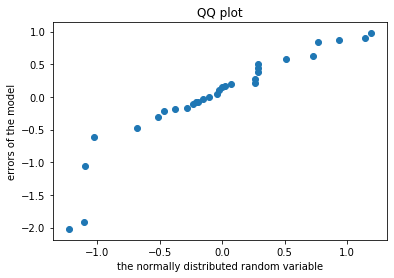

Jarque-Bera P-Val: 0.0013270966998115707
Estimated Skew: -1.3078210957390441
Estimated kurtosis: 4.938565081348959


In [10]:
# Checking that the errors are normally distributed
rand_nums = np.random.normal(np.mean(residuals),
                             np.std(residuals),
                             len(residuals))
plt.scatter(np.sort(rand_nums), np.sort(residuals))
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")
plt.show()

_, pval, skew, kurtosis = jarque_bera(residuals)
print('Jarque-Bera P-Val:', pval)
print('Estimated Skew:', skew)
print('Estimated kurtosis:', kurtosis)

The Jarque-Bera test seems to indicate the errors have kurtosis and skewness consistent with a normal distribution. Without this I could still generate accurate predictions with minimum variance, but this will allow me to determine more accurate confidence intervals or predicton intervals if needed.

In [11]:
# Making sure independent features aren't correlated with residuals
grades[['total_locked', 'house', 'dark']].corrwith(residuals)

total_locked    1.217591e-16
house          -1.489542e-16
dark            7.106792e-17
dtype: float64

They're not correlated at all. That means the residuals from my model are  non-predictable.

### 1.1.1 Analyzing OLS Results

Since the OLS model has met required assumptions, let's check the results. This time let's use the OLS algorithm from statsmodels for a more comprehensive results read-out.

In [12]:
OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                gpa_13s   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):             -0.099
Method:                 Least Squares   F-statistic:                             0.1014
Date:                Sun, 27 Sep 2020   Prob (F-statistic):                       0.958
Time:                        08:32:54   Log-Likelihood:                         -79.305
No. Observations:                  30   AIC:                                      164.6
Df Residuals:                      27   BIC:                                      168.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0362      0.850     -0.043      0.966      -1.781       1.709
x2             0.3636      0.684      0.532      0.599      -1.040       1.767
x3            -0.1459      0.836     -0.175      0.863      -1.862       1.570
==============================================================================
Omnibus:                       13.304   Durbin-Watson:                   0.102
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.250
Skew:                          -1.308   Prob(JB):                      0.00133
Kurtosis:                       4.939   Cond. No.                         2.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since the r-squared is very low, and the standard errors for each variable are fairly high, it's probably safe to say that OLS is not the most appropriate model for our data.

## 1.2 Defining Functions

In [7]:
# Defining function to get metrics from model
def get_results(search, X, y, X_train, X_test, y_train, y_test):
    train_preds = search.best_estimator_.predict(X_train)
    test_preds = search.best_estimator_.predict(X_test)
    print('Best parameters:', search.best_params_)
    print('Cross-val score:', cross_val_score(search.best_estimator_,
                                              X, y,
                                              scoring='neg_mean_absolute_error'))
    print('MAE on train', mean_absolute_error(y_train, train_preds))
    print('R2 on train', r2_score(y_train, train_preds))
    print('MAE on test', mean_absolute_error(y_test, test_preds))
    print('R2 on test', r2_score(y_test, test_preds))

    sns.scatterplot(x=y_train, y=train_preds)
    sns.scatterplot(x=y_test, y=test_preds)
    sns.lineplot(x=y, y=y)
    plt.xlabel('True')
    plt.ylabel('Residual')
    plt.show()

In [8]:
# Defining function to streamline code for RandomizedSearch
def run_search(X, y, model, params, test_size=.1):

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size)

    search = RandomizedSearchCV(
        model,
        params,
        cv=5,
        random_state=42,
        n_iter=15,
        scoring='neg_mean_absolute_error'
    )
    
    search.fit(X_train, y_train)
    get_results(search, X, y, X_train, X_test, y_train, y_test)
    
    sns.barplot(
        y=X.columns,
        x=search.best_estimator_.feature_importances_
    )
    plt.title('Feature Importances')
    
    return search.best_estimator_

## 1.3 Random Forest Regressor

In [9]:
print(len(grades))
grades = grades[grades.gpa_13s > 2.5]
print(len(grades))

30
27


Best parameters: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 8}
Cross-val score: [-0.26976852 -0.30226852 -0.35974794]
MAE on train 0.11436921298458587
R2 on train 0.8645337741286246
MAE on test 0.4261574074444437
R2 on test -0.23039908610547832


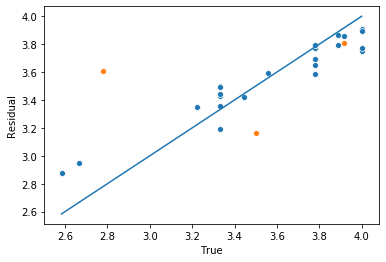

CPU times: user 28.5 s, sys: 556 ms, total: 29.1 s
Wall time: 29.4 s


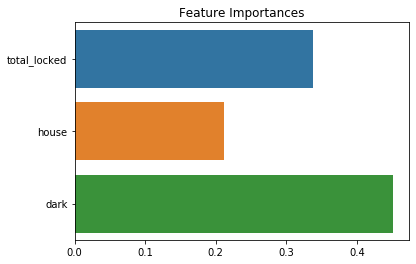

In [10]:
%%time
# Running RFR on the same features as OLS, but not scaled
X = grades[['total_locked', 'house', 'dark']]
y= grades.gpa_13s

rfr = RandomForestRegressor(random_state=42,
                            criterion='mae')

params = {'n_estimators': [150, 175, 200, 250, 300],
          'max_depth': [8, 10, 12],
          'min_samples_split': [2, 3]}

rfr = run_search(X, y, rfr, params)

Random Forest is performing okay on the training data, especially over 2.5 GPA, but is far enough off on test data that it's probably not useful in terms of prediction. Let's try winsorizing the GPA data to see if that helps with the fit at all in terms of noise introduced by outliers. I'll winsorize to about 2.5 GPA since that's about at the lower bound, and also if someone's GPA is at 2.5, that's already a justification for concern/intervention that might not be changed too too much by the GPA being even lower.

Best parameters: {'n_estimators': 200, 'min_samples_split': 3, 'max_depth': 12}
Cross-val score: [-0.2582716  -0.28803241 -0.34568673]
MAE on train 0.10553819444198015
R2 on train 0.8402300407432555
MAE on test 0.4357175926383336
R2 on test -0.5361771929258274


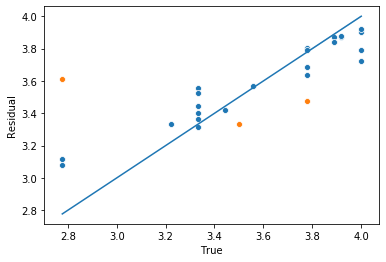

CPU times: user 28.2 s, sys: 762 ms, total: 29 s
Wall time: 29.3 s


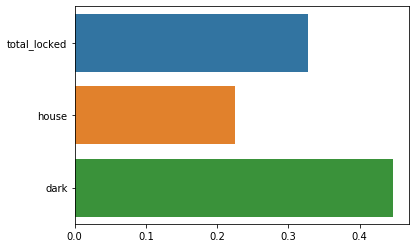

In [38]:
%%time
# Creating winsorized y
X = grades[['total_locked', 'house', 'dark']]
y= grades.gpa_13s

winsorized_y = mstats.winsorize(grades.gpa_13s, (.1, 0))

params = {'n_estimators': [150, 175, 200, 250, 300],
          'max_depth': [8, 10, 12],
          'min_samples_split': [2, 3]}

# Running RFR on winsorized target variable
winsor_rfr = run_search(X, winsorized_y, rfr, params)

Random Forest performed worse on both train and test data when y was winsorized, so we'll discard that as a strategy.

Next I'll run Random Forest on a couple other combinations of features to see if results vary.

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 10}
Cross-val score: [-0.38098765 -0.31310185 -0.41373457]
MAE on train 0.14899305561312828
R2 on train 0.8116436393844817
MAE on test 0.31847222244333045
R2 on test -2.086383351609308


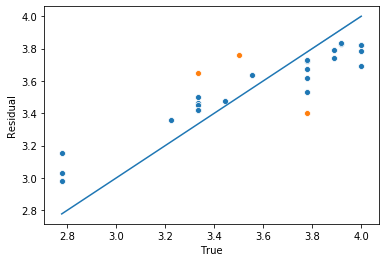

CPU times: user 30.6 s, sys: 588 ms, total: 31.2 s
Wall time: 31.6 s


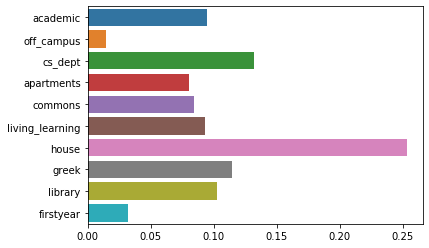

In [39]:
%%time
# Running model on all latlon clusters
latlon_X = grades[['academic', 'off_campus', 'cs_dept', 'apartments', 'commons',
            'living_learning', 'house', 'greek', 'library', 'firstyear']]

# Running RFR
latlon_rfr = run_search(latlon_X, y, rfr, params)

Even with more features, Random Forest isn't performing quite as well as it did with just sensing data for dark, phone locking, and one lat-lon feature, `house`. It's possible I'm drowning my really small number of observations in too much data, so I'm going to cut `X` down to a smaller set of features I'm guessing based on data exploration will be relevant, and we'll see how the model performs. People who spend more time in the department or in the library may do better or worse than average, as may graduate students for first year students.

Best parameters: {'n_estimators': 175, 'min_samples_split': 2, 'max_depth': 10}
Cross-val score: [-0.33146384 -0.29634921 -0.35017637]
MAE on train 0.13861111116452596
R2 on train 0.8199046100875378
MAE on test 0.24645502674476086
R2 on test -0.44682427449353557


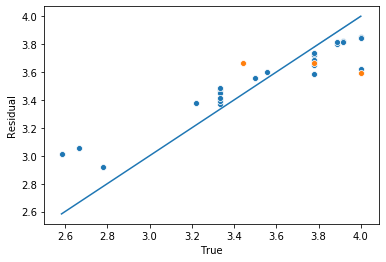

CPU times: user 31.5 s, sys: 731 ms, total: 32.2 s
Wall time: 35.4 s


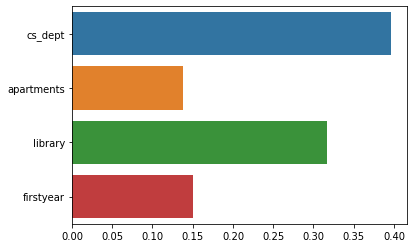

In [40]:
%%time
# Running model on all latlon clusters
latlon_X = grades[['cs_dept', 'apartments', 'library', 'firstyear']]
y = grades.gpa_13s

# Running RFR on winsorized target variable
latlon_rfr = run_search(latlon_X, y, rfr, params)

I'm going to try one more iteration, with the features of highest importance for the lat-lon Random Forest, `cs_dept` and `library`, as well as dark data and conversation data.

In [41]:
print(len(combo_X), len(y))

27 27


Best parameters: {'n_estimators': 175, 'min_samples_split': 3, 'max_depth': 10}
Cross-val score: [-0.42300705 -0.34506173 -0.38824515]
MAE on train 0.14053571433500298
R2 on train 0.8153345061632331
MAE on test 0.401851852053335
R2 on test -1.8995692035690337


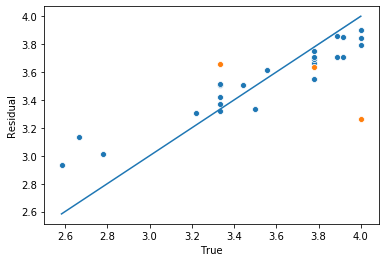

CPU times: user 27.5 s, sys: 485 ms, total: 28 s
Wall time: 28.1 s


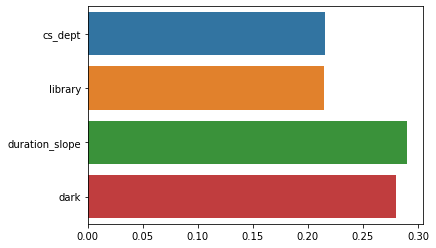

In [42]:
%%time
# Running model on combination of features
combo_X = grades[['cs_dept', 'library', 'duration_slope', 'dark']]

params = {'n_estimators': [150, 175, 200, 250, 300],
          'max_depth': [4, 10, 20, 40, 100],
          'min_samples_split': [2, 3, 4, 5, 6, 7]}

# Running randomized search on random forest
combo_rfr = run_search(combo_X, y, rfr, params, test_size=.1)

Before wrapping up I do just want to confirm that Random Forest won't run as well on all the independent features.

Best parameters: {'n_estimators': 250, 'min_samples_split': 7, 'max_depth': 40}
Cross-val score: [-0.38469753 -0.30967901 -0.4043642 ]
MAE on train 0.1406759260131714
R2 on train 0.6980043674803058
MAE on test 0.6208888889480021
R2 on test -1.058348855494354


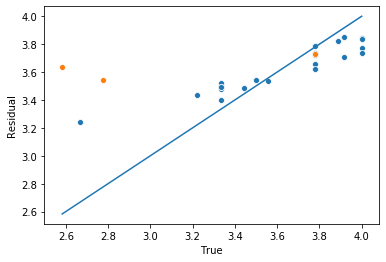

CPU times: user 33.6 s, sys: 850 ms, total: 34.4 s
Wall time: 35.2 s


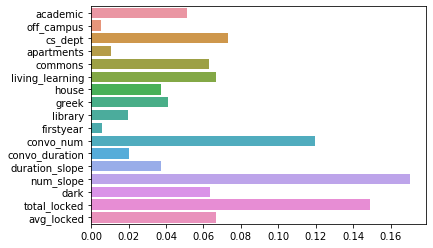

In [43]:
%%time
# Running model on combination of features. Make sure to leave out
# 'primary', which is a categorical variable
all_X = grades[['academic', 'off_campus', 'cs_dept',
       'apartments', 'commons', 'living_learning', 'house', 'greek', 'library',
       'firstyear', 'convo_num', 'convo_duration', 'duration_slope',
       'num_slope', 'dark', 'total_locked', 'avg_locked']]

params = {'n_estimators': [150, 175, 200, 250, 300],
          'max_depth': [4, 10, 20, 40, 100],
          'min_samples_split': [2, 3, 4, 5, 6, 7]}

# Running randomized search on random forest
all_rfr = run_search(all_X, y, rfr, params, test_size=.1)

Well, it's not dramatically worse than some other models, but it definitely doesn't perform as well as our four-feature combination model.

It seems that I've maximized what Random Forest can do in this case, with a 30% absolute error on test data on the final model. However, I have a suspicion that Gradient Boosting will perform better on this dataset due to its small size and lack of danger of overfitting. The small number of observations means the model needs to be able to tease out patterns in the data with very little bandwidth to work in, and I think Gradient Boosting will be able to iteratively build a model of these patterns where Random Forest cannot.

## 1.4 Gradient Boosting Regressor

First, I'm just curious how Gradient Boosting will perform with the full set of features.

In [45]:
all_X = grades[['academic', 'off_campus', 'cs_dept',
       'apartments', 'commons', 'living_learning', 'house', 'greek', 'library',
       'firstyear', 'convo_num', 'convo_duration', 'duration_slope',
       'num_slope', 'dark', 'total_locked', 'avg_locked']]

y = grades.gpa_13s

Best parameters: {'n_estimators': 350, 'min_samples_split': 4, 'max_depth': 1, 'learning_rate': 0.02}
Cross-val score: [-0.40429365 -0.29196846 -0.42671554]
MAE on train 0.08949755104338976
R2 on train 0.856936724919413
MAE on test 0.48515055375618965
R2 on test 0.10993519514648453


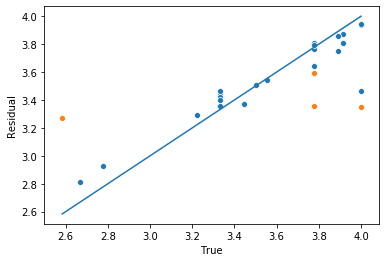

CPU times: user 16.2 s, sys: 247 ms, total: 16.4 s
Wall time: 17.7 s


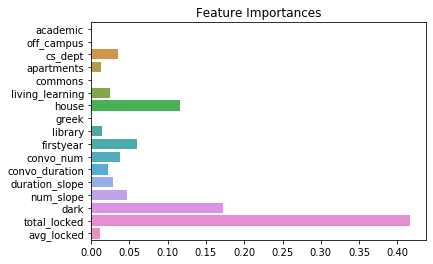

In [46]:
%%time

# Defining parameters
params = {'learning_rate': [.02, .05, .07],
          'n_estimators': list(range(50, 601, 50)),
          'min_samples_split': [2,3,4],
          'max_depth': [1, 3, 5, 40]
         }

# Creating gradient boosting object with MAE criterion
gbr = GradientBoostingRegressor(random_state=42,
                                criterion='mae')

# Running randomized search on gradient boosting regressor
all_gbr = run_search(all_X, y, gbr, params, test_size=.13)

Now I'll filter down to a few features of greatest importance.

In [16]:
def fit_and_results(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=.1)
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    print('MAE on train', mean_absolute_error(y_train, train_preds))
    print('R2 on train', r2_score(y_train, train_preds))
    print('MAE on test', mean_absolute_error(y_test, test_preds))
    print('MAE in GPA', mean_absolute_error(y_test, test_preds))
    print('R2 on test', r2_score(y_test, test_preds))

    sns.scatterplot(x=y_train, y=train_preds)
    sns.scatterplot(x=y_test, y=test_preds)
    sns.lineplot(x=y, y=y)
    plt.xlabel('True')
    plt.ylabel('Residual')
    plt.show()
    
    sns.barplot(
        y=X.columns,
        x=model.feature_importances_
    )

MAE on train 0.1297857165120587
R2 on train 0.8156058706523781
MAE on test 0.5058664727233487
MAE in GPA 0.5058664727233487
R2 on test -0.196300634447226


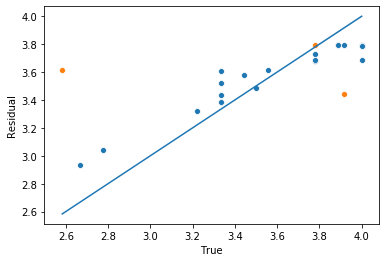

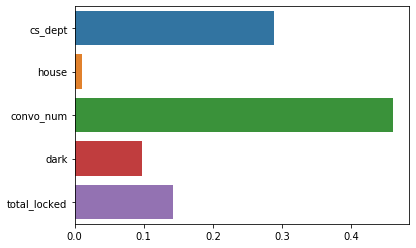

In [25]:
X = grades[['cs_dept', 'house', 'convo_num', 'dark', 'total_locked']]

# Running randomized search on gradient boosting regressor
gbr = GradientBoostingRegressor(
    learning_rate=.005,
    n_estimators=400,
    min_samples_split=4,
    max_depth=2
)

fit_and_results(gbr, X, grades.gpa_13s)

What you may notice if you run this cell more than once, with different data points taken out of the set on each iteration, gradient boosting is pretty unstable with such a small number of observations. Particularly, the model — and I suspect this is true for Random Forest as well — is having trouble accurately classifying the students who have GPAs below 2.5. This makes sense in a way — there are very few students in this range to learn from, so the realtionships they have with the rest of the data may be very erratic. With Random Forest I attempted to winsorize these values in the hopes that the model may simply not be able to account for *how low* they are, but may be able to pick up on similarities between them and the students in the 2.5–3.0 range. Now I'm thinking these observations just add noise to the data, so I'm going to drop those observations entirely and run the model again, still on the reduced feature set.

MAE on train 0.16415363367925398
R2 on train 0.7792282967292921
MAE on test 0.3868083116118859
MAE in GPA 0.3868083116118859
R2 on test -23.406290000695275


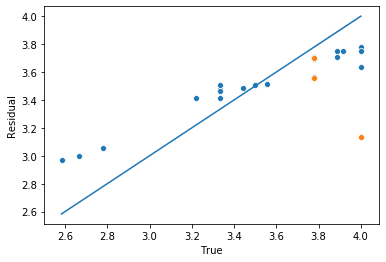

CPU times: user 711 ms, sys: 20.1 ms, total: 731 ms
Wall time: 748 ms


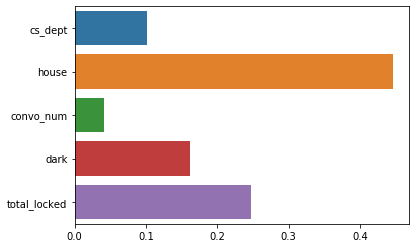

In [26]:
%%time
cleaned_grades = grades[grades.gpa_13s > 2.5]

X = cleaned_grades[['cs_dept', 'house', 'convo_num', 'dark', 'total_locked']]
y = cleaned_grades.gpa_13s

# Running randomized search on gradient boosting regressor
gbr = GradientBoostingRegressor(
    learning_rate=.002,
    n_estimators=500,
    min_samples_split=4,
    max_depth=3
)

fit_and_results(gbr, X, y)

On all the iterations of models I've run, it's never been practical to get below than .25–.30 MAE on the test split for any model. However, the models are also unstable, so spending on where the split it, sometimes MAE spikes to .50–.60. As far as I can tell, this is just an effect of trying to generate a regressive model on so little data.

Before moving on I just want to make sure that the same problem emerges with the cumulative GPA data.

MAE on train 0.11535511805595113
R2 on train 0.8491052159681969
MAE on test 0.14816582744935314
MAE in GPA 0.14816582744935314
R2 on test 0.662279378029967


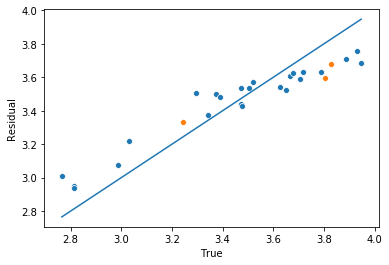

CPU times: user 692 ms, sys: 18.2 ms, total: 711 ms
Wall time: 722 ms


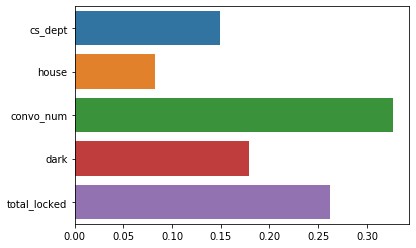

In [27]:
%%time

X = cleaned_grades[['cs_dept', 'house', 'convo_num', 'dark', 'total_locked']]
y = cleaned_grades.gpa_all

# Running randomized search on gradient boosting regressor
gbr = GradientBoostingRegressor(
    learning_rate=.004,
    n_estimators=500,
    min_samples_split=2,
    max_depth=2
)

fit_and_results(gbr, X, y)

The same problem arises, and in addition, even on the training data the model has a propensity regardless of hyperparameters to underestimate high GPAs and overestimate low GPAs. I suppose this just represents a moderating effect on predictions with regards to the target variable. In the case of using this model in a predictive tool, the effect would be — if the model could predict even close as well as it is fitting to the training set — that the model would probably underball a relatively high GPA, or underestimate how bad a low GPA would be.

In [12]:
grades_w_pre_survey = grades.merge(pre_survey, on='uid', how='left').drop(columns=['time'])
        
null_vars = [var for var in grades_w_pre_survey
             if grades_w_pre_survey[var].isnull().sum() > 0]

In [22]:
for var in null_vars:
    grades_w_pre_survey[var] = grades_w_pre_survey.fillna(grades_w_pre_survey[var].mean())
grades_w_pre_survey.isnull().sum().sum()

0

MAE on train 0.1855286469964165
R2 on train 0.6794454328693751
MAE on test 0.2988677579693862
MAE in GPA 0.2988677579693862
R2 on test -0.6302119705777514


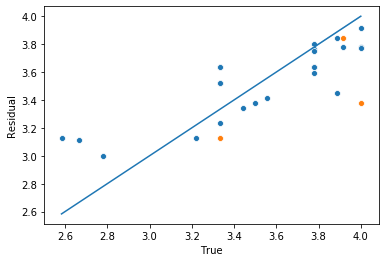

CPU times: user 1.14 s, sys: 27 ms, total: 1.17 s
Wall time: 1.24 s


gpa_all           0.553072
convo_duration   -0.150138
dtype: float64

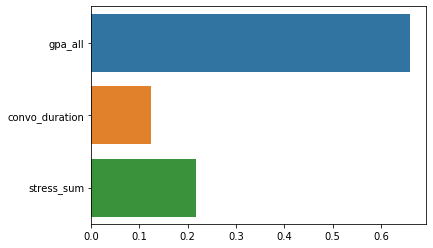

In [30]:
%%time

X = grades_w_pre_survey[['gpa_all', 'convo_duration', 'stress_sum']]
y = grades_w_pre_survey.gpa_13s

# Running randomized search on gradient boosting regressor
app_gbr = GradientBoostingRegressor(
    learning_rate=.003,
    n_estimators=2000,
    min_samples_split=2,
    max_depth=1
)

fit_and_results(app_gbr, X, y)

X.corrwith(y)

Just out of curiosity I'll also run a model with all the features and see how the metrics compare. I'm assuming a full feature set will swamp the 27 observations in noise, so the metrics will at best hold steady, but maybe it'll work out.

MAE on train 0.13038523986863962
R2 on train 0.8525970434822379
MAE on test 0.27745590572874795
MAE in GPA 0.27745590572874795
R2 on test 0.20516348423076336


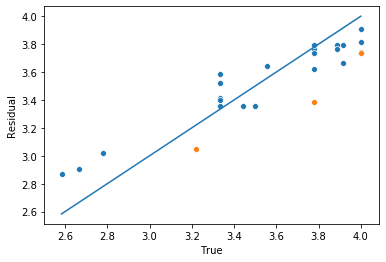

CPU times: user 1.09 s, sys: 21.2 ms, total: 1.11 s
Wall time: 1.11 s


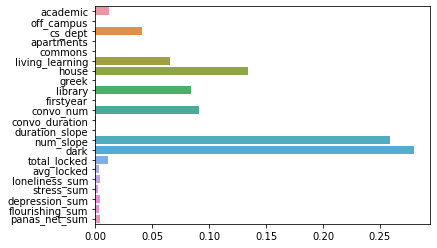

In [30]:
%%time

X = grades_w_pre_survey.drop(['uid', 'gpa_all', 'gpa_13s', 'primary'], axis=1).dropna()
y = grades_w_pre_survey.gpa_13s

# Running randomized search on gradient boosting regressor
full_gbr = GradientBoostingRegressor(
    learning_rate=.003,
    n_estimators=2000,
    min_samples_split=2,
    max_depth=1
)

fit_and_results(full_gbr, X, y)

The model doesn't perform dramtically worse, but there's more variation in the cross validation scores (generated here informally by running the model a few times). We can also see in the feature importances that with a full set the mental health data plays no role in the model, while with a reduced set, it plays an important back up role to the primary indicator.

In [31]:
gbr_for_pickle = app_gbr.fit(X, y)
type(gbr_for_pickle)

sklearn.ensemble.gradient_boosting.GradientBoostingRegressor

# 2. Plotly Dash Web App

For a web application, or machine learning-based product, I want to just create a simple GPA predictor that allows a student to answer a few questions and get a predicted end of term GPA. This would be something that Student Life officers might be interested in providing to students. Of course, if the application were for administrators themselves interested in helping students who might end up not performing well academically, they would need to have access to sensing data

In [32]:
pickle.dump(app_gbr, open("gpr_app.py", "wb"))

In [33]:
path = '/Users/kristiancanler/Documents/data/dartmouth_dataset/python_notebooks/modeling_dash/gpr_app.py'
file = open(path, 'rb')
gbr_pickle = pickle.load(file)

In [54]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

stress_slider_labels = ['None', 'Not much', 'Somewhat', 'Significantly', 'Very Stressed']
stress_slider_values = [10, 20, 30, 40, 50]

app.layout = html.Div([
    html.H6("What is your current cumulative GPA?"),
    dcc.Slider(
        id='gpa--slider',
        min=grades_w_pre_survey.gpa_all.min(),
        max=grades_w_pre_survey.gpa_all.max(),
        marks={round(gpa, 1): str(round(gpa,1)) for gpa in
               np.arange(2.5, 4, 0.1)
              },
        step=None
    ),
    html.Br(),
    html.H6("Would you say you have longer or shorter conversations than average (10 minutes)?"),
    dcc.Slider(
        id='length--slider',
        min=grades_w_pre_survey.convo_duration.min(),
        max=grades_w_pre_survey.convo_duration.max(),
        value=grades_w_pre_survey.convo_duration.min(),
        marks={length: str(round(length/66)) for length in
               np.arange(grades_w_pre_survey.convo_duration.min(),
                         grades_w_pre_survey.convo_duration.max(),
                         grades_w_pre_survey.convo_duration.std())
              },
        step=None
    ),
    html.Br(),
        html.H6("How stressed did you feel around the start of the semester?"),
    dcc.Slider(
        id='stress--slider',
        min=grades_w_pre_survey.stress_sum.min(),
        max=grades_w_pre_survey.stress_sum.max(),
        value=grades_w_pre_survey.stress_sum.min(),
        marks={stress_slider_values[i]: stress_slider_labels[i]
               for i,e in enumerate(stress_slider_values)
              },
        step=None
    ),
    html.Br(),
    html.Div(id='my-output')
])


@app.callback(
    Output(component_id='my-output', component_property='children'),
    [Input(component_id='gpa--slider', component_property='value'),
     Input(component_id='length--slider', component_property='value'),
     Input(component_id='stress--slider', component_property='value')]
)  
def update_output_div(gpa_value, length_value, stress_value):
    pred = gbr_pickle.predict(
        np.array([gpa_value, length_value, stress_value-10]).reshape(1,-1)
    )
    pred = round(pred[0], 3)
    return 'Your predicted spring GPA is: {}'.format(pred)


if __name__ == '__main__':
    app.run_server(mode='inline')

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-54-410d1a646056> in update_output_div(
    gpa_value=None,
    length_value=393.54051407588736,
    stress_value=2
)
     56 def update_output_div(gpa_value, length_value, stress_value):
     57     pred = gbr_pickle.predict(
---> 58         np.array([gpa_value, length_value, stress_value-10]).reshape(1,-1)
        global np.array = <built-in function array>
        gpa_value = None
        length_value = 393.54051407588736
        stress_value.reshape = undefined
     59     )
     60     pred = round(pred[0], 3)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py in predict(
    self=GradientBoostingRegressor(alpha=0.9, criterion='...dation_fraction=0.1, verbose=0, warm_start=False),
    X=array([[None, 393.54051407588736, -8]], dtype=object)
)
   2528             The predicted values.
   2